# 1. Install Dependencies and Setup

In [4]:
!pip install tensorflow opencv-python matplotlib

In [5]:
import tensorflow as tf
import os

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-23 02:37:11.531383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 02:37:11.532163: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
tf.config.list_physical_devices('GPU')

[]

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 250 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

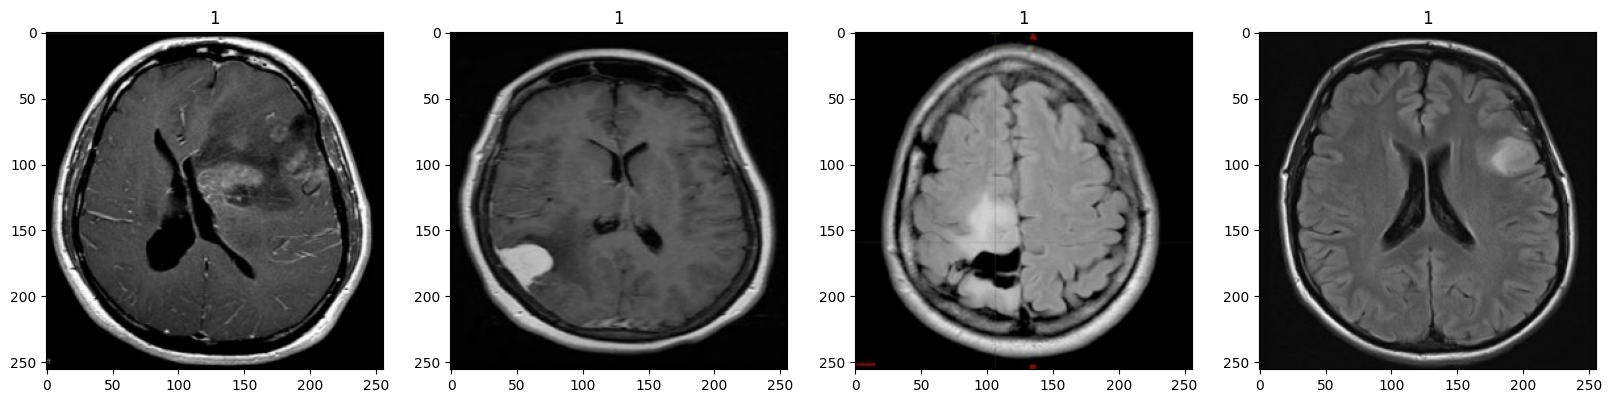

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [0.9293574 , 0.9293574 , 0.9293574 ],
          [0.2315817 , 0.2315817 , 0.2315817 ],
          ...,
          [0.9994806 , 0.9994806 , 0.9994806 ],
          [0.99912786, 0.99912786, 0.99912786],
          [0.99525124, 0.99525124, 0.99525124]],
 
         [[0.9987592 , 0.9987592 , 0.9987592 ],
          [0.92654115, 0.92654115, 0.92654115],
          [0.25561816, 0.25561816, 0.25561816],
          ...,
          [0.9899987 , 0.9899987 , 0.9899987 ],
          [0.99316025, 0.99316025, 0.99316025],
          [0.97977173, 0.97977173, 0.97977173]],
 
         [[0.9942249 , 0.9942249 , 0.9942249 ],
          [0.9367747 , 0.9367747 , 0.9367747 ],
          [0.23958416, 0.23958416, 0.23958416],
          ...,
          [0.9904792 , 0.9904792 , 0.9904792 ],
          [0.99207854, 0.99207854, 0.99207854],
          [0.9795726 , 0.9795726 , 0.9795726 ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [0.94309

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

5

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-11-23 02:37:14.358448: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-11-23 02:37:14.359244: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.
2023-11-23 02:37:14.478763: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.
2023-11-23 02:37:14.619578: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.
2023-11-23 02:37:14.850915: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66064384 exceeds 10% of free system memory.
2023-11-23 02:37:14.851001: W external/local_tsl/tsl/framework/cpu_al

5/5 [==============================] - 5s 807ms/step - loss: 0.7900 - accuracy: 0.5437 - val_loss: 0.4247 - val_accuracy: 0.8438


2023-11-23 02:37:18.159954: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 2/20
5/5 [==============================] - 4s 740ms/step - loss: 0.5200 - accuracy: 0.7375 - val_loss: 0.5985 - val_accuracy: 0.6875
Epoch 3/20


2023-11-23 02:37:23.074086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 4s 678ms/step - loss: 0.4723 - accuracy: 0.8000 - val_loss: 0.7474 - val_accuracy: 0.6875
Epoch 4/20


2023-11-23 02:37:26.589518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 4s 692ms/step - loss: 0.4684 - accuracy: 0.8125 - val_loss: 0.4186 - val_accuracy: 0.8438
Epoch 5/20


2023-11-23 02:37:30.108351: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 642ms/step - loss: 0.3912 - accuracy: 0.8625 - val_loss: 0.4520 - val_accuracy: 0.8125
Epoch 6/20


2023-11-23 02:37:33.638208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 659ms/step - loss: 0.3873 - accuracy: 0.8438 - val_loss: 0.2360 - val_accuracy: 0.8750
Epoch 7/20


2023-11-23 02:37:37.040480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 659ms/step - loss: 0.2817 - accuracy: 0.8687 - val_loss: 0.3685 - val_accuracy: 0.8438
Epoch 8/20


2023-11-23 02:37:40.424008: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 649ms/step - loss: 0.2790 - accuracy: 0.9000 - val_loss: 0.1702 - val_accuracy: 0.9688
Epoch 9/20


2023-11-23 02:37:43.763900: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 4s 706ms/step - loss: 0.2000 - accuracy: 0.9375 - val_loss: 0.1353 - val_accuracy: 0.9688
Epoch 10/20


2023-11-23 02:37:47.303945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 668ms/step - loss: 0.1848 - accuracy: 0.9312 - val_loss: 0.1302 - val_accuracy: 0.9688
Epoch 11/20
5/5 [==============================] - 3s 651ms/step - loss: 0.1303 - accuracy: 0.9500 - val_loss: 0.0715 - val_accuracy: 1.0000
Epoch 12/20


2023-11-23 02:37:54.094146: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 654ms/step - loss: 0.1256 - accuracy: 0.9563 - val_loss: 0.0894 - val_accuracy: 0.9688
Epoch 13/20


2023-11-23 02:37:57.487910: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 670ms/step - loss: 0.1165 - accuracy: 0.9625 - val_loss: 0.1323 - val_accuracy: 0.9375
Epoch 14/20


2023-11-23 02:38:00.895766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 669ms/step - loss: 0.1037 - accuracy: 0.9688 - val_loss: 0.0439 - val_accuracy: 1.0000
Epoch 15/20


2023-11-23 02:38:04.371673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 681ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.0978 - val_accuracy: 0.9375
Epoch 16/20


2023-11-23 02:38:07.892035: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 664ms/step - loss: 0.0476 - accuracy: 0.9875 - val_loss: 0.0472 - val_accuracy: 1.0000
Epoch 17/20
5/5 [==============================] - 3s 669ms/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9688
Epoch 18/20


2023-11-23 02:38:14.724632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 4s 722ms/step - loss: 0.0446 - accuracy: 0.9812 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 19/20


2023-11-23 02:38:18.355113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 665ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 20/20


2023-11-23 02:38:21.848326: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 [==============================] - 3s 659ms/step - loss: 0.0337 - accuracy: 0.9937 - val_loss: 0.0123 - val_accuracy: 1.0000


2023-11-23 02:38:25.276638: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


# 8. Plot Performance

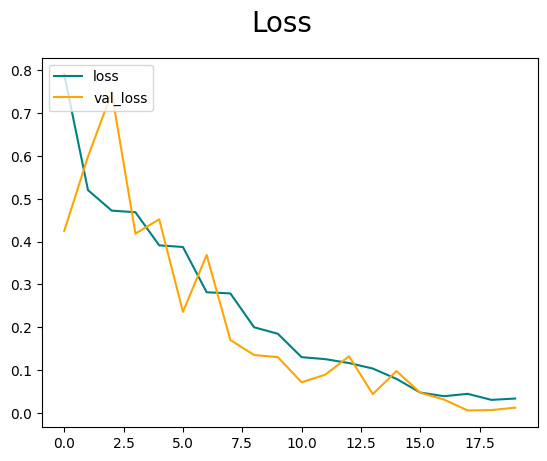

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

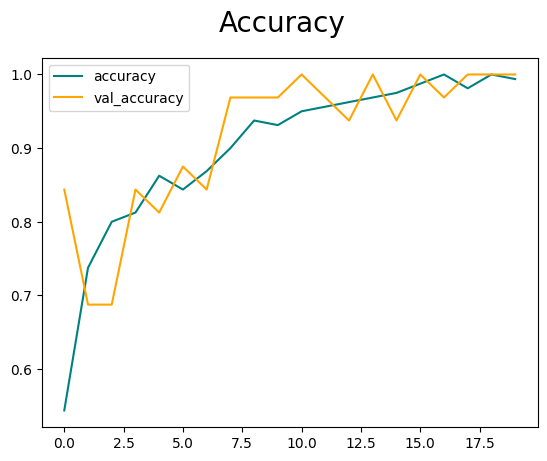

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

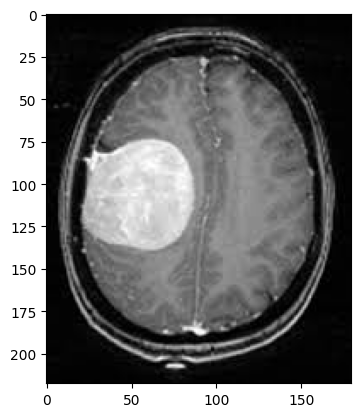

In [34]:
img = cv2.imread('Y1.jpg')
plt.imshow(img)
plt.show()

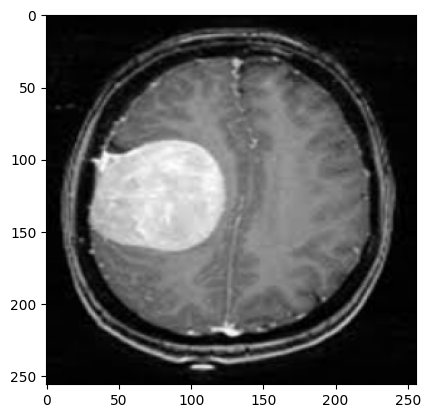

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 71ms/step


In [37]:
yhat

array([[0.9999656]], dtype=float32)

In [38]:
if yhat > 0.5: 
    print(f'Predicted class is Yes')
else:
    print(f'Predicted class is No')

Predicted class is Yes


# 11. Save the Model

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('models','imageclassifier.h5'))

/home/neonnex/Development/deep_learning/BrainMRIClassification/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [42]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 55ms/step


In [43]:
if yhatnew > 0.5: 
    print(f'Predicted class is Yes')
else:
    print(f'Predicted class is No')

Predicted class is Yes
